# Preprocesamiento de la Data y Modelado de Churn (Proyecto Final - "DesafÍA la IA" Predicción de rotación de clientes (Churn) en una empresa de Telecomunicaciones)

**Descripción:** En este notebook está contemplada la etapa donde se preparan los datos para entrenamiento, se construyen modelos de predicción y se evalúa su desempeñode.  
**Autor:** Erik González Molina


In [12]:
# Importamos las librerías necesarias para preprocesamiento y modelado
import pandas as pd
import numpy as np
import os
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## 1. Carga de la Data limpia  
Se carga la Data limpia (telco_customer_churn.csv). La variable objetivo Churn será transformada a formato binario (Yes → 1, No → 0) para su uso en modelos de clasificación.  
### Carga de Data  


In [13]:
# Cargamos los datos en mi variable data
data = pd.read_csv('../Data/telco_customer_churn.csv')
# Visualizamos las primeras 5 filas.
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Convertimos la Data

In [14]:
# Convertimos la variable objetivo 'Churn' a formato numérico (Yes → 1, No → 0)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
# Confirmamos que la conversión se haya hecho correctamente
print("\nDistribución de la variable 'Churn' después de la conversión:")
print(data['Churn'].value_counts())


Distribución de la variable 'Churn' después de la conversión:
Churn
0    5174
1    1869
Name: count, dtype: int64


## 2. Identificación y Separación de Variables  
Separamos las variables en **numéricas** y **categóricas** para aplicar el preprocesamiento adecuado a cada tipo:

- Las variables categóricas se codificarán (LabelEncoder o One-Hot Encoding).
- Las numéricas pueden ser escaladas posteriormente si el modelo lo requiere.

In [15]:
# Visualizamos tipos de datos únicos por columna
print("Tipos de datos en el dataset:\n")
print(data.dtypes)
# Identificamos variables categóricas (tipo 'object') y algunas binarias (como SeniorCitizen que es int, pero categórica)
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Aunque es numérica, es binaria → tratada como categórica
# Excluimos la variable objetivo ('Churn') de las predictoras
categorical_cols = [col for col in categorical_cols if col != 'Churn']
# Variables numéricas (reales, no categóricas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')  # Ya la tratamos como categórica
numeric_cols.remove('Churn')          # Es la variable objetivo
# Mostramos el resultado
print("\nVariables categóricas:")
print(categorical_cols)
print("Variables numéricas:")
print(numeric_cols)


Tipos de datos en el dataset:

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

Variables categóricas:
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'SeniorCitizen']
Variables numéricas:
['tenure', 'MonthlyCharges']


## 3. Limpieza de columnas no predictivas y corrección de tipos
- Se elimina la columna customerID, ya que es solo un identificador único y no aporta valor predictivo.
- Se convierte TotalCharges de texto a numérico.
- Se actualiza la lista de variables categóricas para excluir columnas no relevantes.

In [16]:
# Eliminamos la columna identificador (customerID)
if 'customerID' in data.columns:
    data.drop(columns='customerID', inplace=True)
    print("Columna 'customerID' eliminada.")
# Convertimos 'TotalCharges' a numérico (por si sigue como texto)
if data['TotalCharges'].dtype == 'object':
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    nulos_totalcharges = data['TotalCharges'].isnull().sum()
    print(f"'TotalCharges' convertida a float. Valores nulos detectados: {nulos_totalcharges}")
    # Eliminamos filas con valores faltantes en TotalCharges (si existen)
    if nulos_totalcharges > 0:
        data = data.dropna(subset=['TotalCharges'])
        print("Filas con 'TotalCharges' nulo eliminadas.")
# Confirmamos tipo actualizado
print(f"\nTipo actual de 'TotalCharges': {data['TotalCharges'].dtype}")
# Actualizamos lista de variables categóricas
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Es binaria, la tratamos como categórica
categorical_cols = [col for col in categorical_cols if col != 'Churn']  # Excluimos la variable objetivo
# Variables numéricas (ya actualizadas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')
numeric_cols.remove('Churn')
# Resumen actualizado
print("\nVariables categóricas actualizadas:")
print(categorical_cols)
print("\nVariables numéricas actualizadas:")
print(numeric_cols)

Columna 'customerID' eliminada.
'TotalCharges' convertida a float. Valores nulos detectados: 11
Filas con 'TotalCharges' nulo eliminadas.

Tipo actual de 'TotalCharges': float64

Variables categóricas actualizadas:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Variables numéricas actualizadas:
['tenure', 'MonthlyCharges', 'TotalCharges']


## 4. Codificación de Variables Categóricas  
En este paso se codifican todas las variables categóricas para que puedan ser utilizadas por modelos de machine learning:

1. Variables **binarias** (como Yes/No, Male/Female, SeniorCitizen) se codifican usando LabelEncoder.
2. Variables **multiclase** (como Contract, PaymentMethod) se codifican mediante **One-Hot Encoding** usando pd.get_dummies().  

Este enfoque permite mantener interpretabilidad y compatibilidad con distintos algoritmos.

In [17]:
from sklearn.preprocessing import LabelEncoder
# Inicializamos codificador para variables binarias
le = LabelEncoder()
# Creamos una copia del dataframe para codificación
data_encoded = data.copy()
# Codificamos variables binarias (2 categorías)
binary_cols = [col for col in categorical_cols if data[col].nunique() == 2]
print(" Codificando variables binarias con LabelEncoder:")
for col in binary_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])
    print(f" - {col}: {data[col].unique().tolist()} → {le.classes_.tolist()}")
# El resto se codifica con One-Hot Encoding
multiclass_cols = [col for col in categorical_cols if col not in binary_cols]
# One-hot encoding → evita colinealidad dejando drop_first=True
data_encoded = pd.get_dummies(data_encoded, columns=multiclass_cols, drop_first=True)
# Resultado final
print(f"\n Dataset codificado con {data_encoded.shape[1]} columnas.")
print(" Variables binarias codificadas:", binary_cols)
print(" Variables multiclase codificadas con one-hot:", multiclass_cols)

 Codificando variables binarias con LabelEncoder:
 - gender: ['Female', 'Male'] → ['Female', 'Male']
 - Partner: ['Yes', 'No'] → ['No', 'Yes']
 - Dependents: ['No', 'Yes'] → ['No', 'Yes']
 - PhoneService: ['No', 'Yes'] → ['No', 'Yes']
 - PaperlessBilling: ['Yes', 'No'] → ['No', 'Yes']
 - SeniorCitizen: [0, 1] → [0, 1]

 Dataset codificado con 31 columnas.
 Variables binarias codificadas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
 Variables multiclase codificadas con one-hot: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


## 5. División de Variables y Separación del Dataset  

Se separa la variable objetivo (y = Churn) del resto de variables predictoras (X).
Luego se divide el dataset en 3 subconjuntos:

- 70% para entrenamiento (X_train, y_train)
- 15% para validación (X_val, y_val)
- 15% para prueba final (X_test, y_test)

Esto permite evaluar el modelo durante el desarrollo (validación) y al final (test) de forma independiente.

In [18]:
from sklearn.model_selection import train_test_split
#  Variable objetivo
y = data_encoded['Churn']
#  Variables predictoras (todas las demás)
X = data_encoded.drop(columns='Churn')
#  División inicial: entrenamiento + resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
#  División del 30% restante en validación y test (50/50 del 30% → 15% y 15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
#  Verificación de tamaños
print(" Tamaños de los subconjuntos:")
print(f"- X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"- X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"- X_test:  {X_test.shape}, y_test:  {y_test.shape}")
#  Verificación de balance
print("\n Distribución de clases en los subconjuntos:")
print("Entrenamiento:\n", y_train.value_counts(normalize=True).round(2))
print("Validación:\n", y_val.value_counts(normalize=True).round(2))
print("Test:\n", y_test.value_counts(normalize=True).round(2))

 Tamaños de los subconjuntos:
- X_train: (4922, 30), y_train: (4922,)
- X_val:   (1055, 30), y_val:   (1055,)
- X_test:  (1055, 30), y_test:  (1055,)

 Distribución de clases en los subconjuntos:
Entrenamiento:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Validación:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Test:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64


## 6. Modelo Base: Regresión Lógica  
Entrenamos un primer modelo con LogisticRegression para tener un punto de comparación inicial.
Se evalúa su desempeño con las siguientes métricas:

- Matriz de confusión
- Accuracy, Precision, Recall, F1-score
- Curva AUC-ROC

 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.70      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.77      1055
weighted avg       0.82      0.82      0.82      1055

 Matriz de confusión:
[[700  74]
 [111 170]]
 AUC-ROC: 0.8532


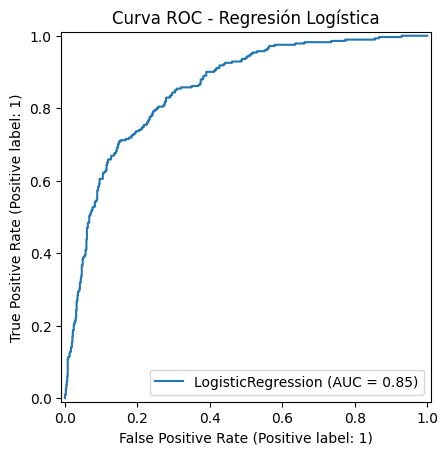

In [21]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
# Instanciamos y entrenamos el modelo
log_model = LogisticRegression(max_iter=3000, random_state=42)
log_model.fit(X_train, y_train)
# Predicción en el conjunto de validación
y_pred = log_model.predict(X_val)
y_prob = log_model.predict_proba(X_val)[:, 1]  # Probabilidad para curva ROC
# Reporte de métricas
print(" Reporte de clasificación:")
print(classification_report(y_val, y_pred))
#  Matriz de confusión
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred))
#  AUC-ROC
auc_score = roc_auc_score(y_val, y_prob)
print(f" AUC-ROC: {auc_score:.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(log_model, X_val, y_val)
plt.title("Curva ROC - Regresión Logística")
plt.savefig(os.path.join(output_folder, 'Curva_ROC'), dpi=300)
plt.show()